In [102]:
# Step 1: Import libraries
import numpy as np    #for numerical, arrays, vectorized maths
import pandas as pd   # read csv and preprocessing
import matplotlib.pyplot as plt  # for plotting

In [103]:
# Step 2: read data (load traces)
traceFilePath="../data/aes_power_tracesNew_28_07_2025_100k.csv"

In [104]:
# if using google colab 
# from google.colab import drive
#drive.mount('/content/drive')
# traceFilePath= '/content/drive/MyDrive/cs666/a2_cpa_aes/data/aes_power_tracesNew_28_07_2025_100k.csv'

In [105]:

# count traces
total_traces = 0
with open(traceFilePath, 'r') as f:
    next(f)  # skip first row if header
    for line in f:
        total_traces += 1
print("Total traces (D):", total_traces)
D=total_traces

# Read first row to detect number of columns
# df_sample = pd.read_csv(traceFilePath,nrows=10) 
traceFile = pd.read_csv(traceFilePath, header=None, skiprows=1, nrows=10)
total_cols = traceFile.shape[1]
N = total_cols - 2
print (" Column 0: Plain text, column 1: Cipher text, col 2-1248 samples per trace")
print("Number of power samples per trace (N):", N)
print("D",total_traces,"N=",N)

print("Full CSV shape:", traceFile.shape)
# print("\nFirst 5 rows of CSV:")
# print(traceFile.head(2))

# print("\nFirst trace row (all columns):")
# print(traceFile.iloc[0, :])

print("\nNumber of columns in first 5 rows:")
for i in range(5):
    print(f"Row {i}: {len(traceFile.iloc[i, :])}")


Total traces (D): 100000
 Column 0: Plain text, column 1: Cipher text, col 2-1248 samples per trace
Number of power samples per trace (N): 1249
D 100000 N= 1249
Full CSV shape: (10, 1251)

Number of columns in first 5 rows:
Row 0: 1251
Row 1: 1251
Row 2: 1251
Row 3: 1251
Row 4: 1251


In [106]:
import numpy as np

# AES inverse S-box (0-255)
inv_sbox = np.array([
    0x52,0x09,0x6a,0xd5,0x30,0x36,0xa5,0x38,0xbf,0x40,0xa3,0x9e,0x81,0xf3,0xd7,0xfb,
    0x7c,0xe3,0x39,0x82,0x9b,0x2f,0xff,0x87,0x34,0x8e,0x43,0x44,0xc4,0xde,0xe9,0xcb,
    0x54,0x7b,0x94,0x32,0xa6,0xc2,0x23,0x3d,0xee,0x4c,0x95,0x0b,0x42,0xfa,0xc3,0x4e,
    0x08,0x2e,0xa1,0x66,0x28,0xd9,0x24,0xb2,0x76,0x5b,0xa2,0x49,0x6d,0x8b,0xd1,0x25,
    0x72,0xf8,0xf6,0x64,0x86,0x68,0x98,0x16,0xd4,0xa4,0x5c,0xcc,0x5d,0x65,0xb6,0x92,
    0x6c,0x70,0x48,0x50,0xfd,0xed,0xb9,0xda,0x5e,0x15,0x46,0x57,0xa7,0x8d,0x9d,0x84,
    0x90,0xd8,0xab,0x00,0x8c,0xbc,0xd3,0x0a,0xf7,0xe4,0x58,0x05,0xb8,0xb3,0x45,0x06,
    0xd0,0x2c,0x1e,0x8f,0xca,0x3f,0x0f,0x02,0xc1,0xaf,0xbd,0x03,0x01,0x13,0x8a,0x6b,
    0x3a,0x91,0x11,0x41,0x4f,0x67,0xdc,0xea,0x97,0xf2,0xcf,0xce,0xf0,0xb4,0xe6,0x73,
    0x96,0xac,0x74,0x22,0xe7,0xad,0x35,0x85,0xe2,0xf9,0x37,0xe8,0x1c,0x75,0xdf,0x6e,
    0x47,0xf1,0x1a,0x71,0x1d,0x29,0xc5,0x89,0x6f,0xb7,0x62,0x0e,0xaa,0x18,0xbe,0x1b,
    0xfc,0x56,0x3e,0x4b,0xc6,0xd2,0x79,0x20,0x9a,0xdb,0xc0,0xfe,0x78,0xcd,0x5a,0xf4,
    0x1f,0xdd,0xa8,0x33,0x88,0x07,0xc7,0x31,0xb1,0x12,0x10,0x59,0x27,0x80,0xec,0x5f,
    0x60,0x51,0x7f,0xa9,0x19,0xb5,0x4a,0x0d,0x2d,0xe5,0x7a,0x9f,0x93,0xc9,0x9c,0xef,
    0xa0,0xe0,0x3b,0x4d,0xae,0x2a,0xf5,0xb0,0xc8,0xeb,0xbb,0x3c,0x83,0x53,0x99,0x61,
    0x17,0x2b,0x04,0x7e,0xba,0x77,0xd6,0x26,0xe1,0x69,0x14,0x63,0x55,0x21,0x0c,0x7d
], dtype=np.uint8)

# Precompute Hamming weight lookup table for 0-255
hw_table = np.unpackbits(np.arange(256, dtype=np.uint8)[:, None], axis=1).sum(axis=1)


Now we will build H matrix

In [107]:
# Step 3: Load dataset (small chunk first for testing)
usedD=20000
traceFile =T= pd.read_csv(traceFilePath,header=None,skiprows=1, nrows=usedD) # header=None to avoid panda to use first row as column identity
# print(traceFile.head())
# print(traceFile.columns)

In [108]:
# Extract the target ciphertext byte (example: byte index 0)
# Convert hex string to integer
c_bytes = traceFile[1].apply(lambda x: int(x[0:2], 16)).to_numpy(dtype=np.uint8)  # pick first byte for example

In [109]:
# Build H
G=256  # key guess [0....255]
# Initialize H matrix
H = np.zeros((usedD, G), dtype=np.uint8)
for d in range(usedD):
    for g in range(G):
        V = inv_sbox[c_bytes[d] ^ g]      # V(d,g) = S⁻¹(C[d] ⊕ k_g)
        H[d, g] = hw_table[V]             # HW(V)

In [110]:
# c_bytes shape: (D,)
# Expand to (D x 256) for all guesses
#V_all = np.bitwise_xor(c_bytes[:, None], np.arange(256, dtype=np.uint8)[None, :])
# Apply inverse S-box
# V_all = inv_sbox[V_all]
# Convert to Hamming weight
# H = hw_table[V_all]  # shape: (D, 256)


In [112]:
#just to confirm H matrix
print("H shape:", H.shape)   # Should be (number_of_traces, 256)
print("H dtype:", H.dtype)   # Usually uint8 or int
print("H sample (first 5 traces, first 10 guesses):")
print(H[:5, :10])
print("Min value in H:", H.min())  #0
print("Max value in H:", H.max())  #8

d = 0
g = 42  # example key guess
V = inv_sbox[c_bytes[d] ^ g]
hw_manual = bin(V).count('1')
print("Manual HW:", hw_manual)
print("H[0,42]:", H[d, g])
import matplotlib.pyplot as plt

# plt.hist(H.flatten(), bins=range(10), edgecolor='k')
# plt.title("Histogram of Hamming weights in H")
# plt.xlabel("Hamming weight")
# plt.ylabel("Frequency")
# plt.show()


H shape: (20000, 256)
H dtype: uint8
H sample (first 5 traces, first 10 guesses):
[[1 4 4 2 5 6 4 1 3 4]
 [2 6 6 7 7 1 4 5 2 4]
 [3 4 4 5 3 3 5 5 4 2]
 [3 5 5 3 4 5 2 5 3 4]
 [5 6 4 5 4 7 4 4 7 4]]
Min value in H: 0
Max value in H: 8
Manual HW: 2
H[0,42]: 2


In [113]:
T = traceFile.iloc[:, 2:].to_numpy(dtype=np.float32)  # shape (D, N)

print("Power trace matrix shape:", traceFile.shape)
print("Power trace matrix shape:", T.shape)
print("H matrix shape:", H.shape)

Power trace matrix shape: (20000, 1251)
Power trace matrix shape: (20000, 1249)
H matrix shape: (20000, 256)


In [114]:
# # Extract power traces only
# T = traceFile.iloc[:, 2:].to_numpy(dtype=np.float32)  # shape (D, N)

# print("H matrix shape:", H.shape)
# print("Power trace matrix shape:", T.shape)


# H = np.array(H, dtype=np.uint8)    # H: (D, 256)
# T = np.array(T, dtype=np.float32)  # T: (D, N)



# D, G = H.shape
# _, N = T.shape

# # Initialize correlation matrix (G x N)
# corr_matrix = np.zeros((G, N))

# # Compute correlation for each guess g and each sample point n
# for g in range(G):
#     for n in range(N):
#         # Pearson correlation formula
#         h = H[:, g]
#         t = T[:, n]
#         corr = np.corrcoef(h, t)[0, 1]  # 2x2 corrcoef → pick [0,1]
#         corr_matrix[g, n] = corr

# print("Correlation matrix shape:", corr_matrix.shape)


In [115]:
# Subtract mean along traces (axis=0)
H_centered = H - H.mean(axis=0, keepdims=True)  # shape D x 256
T_centered = T - T.mean(axis=0, keepdims=True)  # shape D x N

# Compute numerator: covariance between H[:, g] and T[:, n] for all g,n
# H_centered.T @ T_centered → shape 256 x N
numerator = H_centered.T @ T_centered  # matrix multiplication

# Compute denominator: std(H[:, g]) * std(T[:, n])
std_H = H_centered.std(axis=0)[:, None]  # shape 256 x 1
std_T = T_centered.std(axis=0)[None, :]  # shape 1 x N
denominator = std_H * std_T

# Pearson correlation matrix
corr_matrix_fast = numerator / denominator

print("Correlation matrix shape:", corr_matrix_fast.shape)


Correlation matrix shape: (256, 1249)


Most likely key byte (0-255): 34


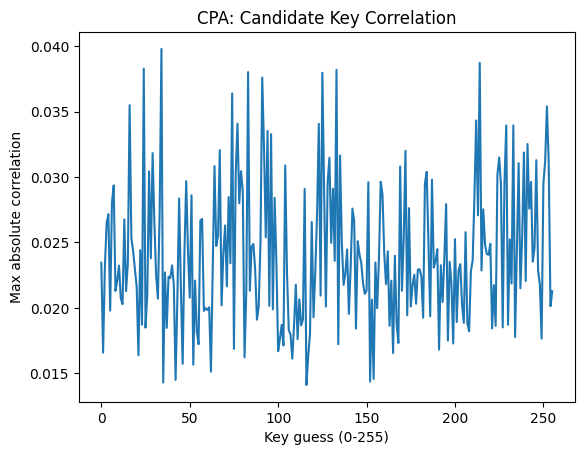

In [116]:
import matplotlib.pyplot as plt

# Find key guess with max absolute correlation across all sample points
guess_max = np.argmax(np.max(np.abs(corr_matrix), axis=1))
print("Most likely key byte (0-255):", guess_max)

# Optional: plot correlation for all guesses
plt.plot(np.max(np.abs(corr_matrix), axis=1))
plt.xlabel("Key guess (0-255)")
plt.ylabel("Max absolute correlation")
plt.title("CPA: Candidate Key Correlation")
plt.show()
